In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

In [3]:
data_excel = '/content/drive/MyDrive/Part 4. 인공지능의 이해 Lv.3 _ 인공지능의 이해를 바탕으로 한 실습/dataset/exercise4.csv'

In [4]:
data = pd.read_csv(data_excel)
data.head()

,processed,label
0,One reviewer mentioned watching Oz episode hoo...,1
1,A wonderful little production . The filming te...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Mattei Love Time Money visually stunnin...,1


In [5]:
data['preocessed'] = data['processed'].str.lower().replace(r"[^a-zA-Z ]","",regex=True)

In [6]:
data['preocessed'][0]

'one reviewer mentioned watching oz episode hooked  they right  exactly happened  the first thing struck oz brutality unflinching scene violence  set right word go  trust  show faint hearted timid  this show pull punch regard drug  sex violence  its hardcore  classic use word  it called oz nickname given oswald maximum security state penitentary  it focus mainly emerald city  experimental section prison cell glass front face inwards  privacy high agenda  em city home many   aryans  muslims  gangsta  latinos  christians  italians  irish     scuffle  death stare  dodgy dealing shady agreement never far away  i would say main appeal show due fact go show dare  forget pretty picture painted mainstream audience  forget charm  forget romance    oz mess around  the first episode i ever saw struck nasty surreal  i say i ready  i watched  i developed taste oz  got accustomed high level graphic violence  not violence  injustice crooked guard sold nickel  inmate kill order get away  well mannered

In [7]:
reviews = data['preocessed'].values
words = ' '.join(reviews).split()
words[0]

'one'

In [8]:
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab,1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}
word2int

{'i': 1,
 'movie': 2,
 'film': 3,
 'the': 4,
 'one': 5,
 'like': 6,
 'it': 7,
 'time': 8,
 'this': 9,
 'good': 10,
 'character': 11,
 'story': 12,
 'even': 13,
 'get': 14,
 'would': 15,
 'make': 16,
 'see': 17,
 'really': 18,
 'scene': 19,
 'well': 20,
 'much': 21,
 'bad': 22,
 'people': 23,
 'great': 24,
 'also': 25,
 'first': 26,
 'show': 27,
 'way': 28,
 'made': 29,
 'thing': 30,
 'could': 31,
 'life': 32,
 'think': 33,
 'go': 34,
 'but': 35,
 'know': 36,
 'watch': 37,
 'and': 38,
 'love': 39,
 'plot': 40,
 'two': 41,
 'actor': 42,
 'many': 43,
 'seen': 44,
 'a': 45,
 'say': 46,
 'year': 47,
 'never': 48,
 'end': 49,
 'acting': 50,
 'look': 51,
 'best': 52,
 'little': 53,
 'in': 54,
 'there': 55,
 'ever': 56,
 'man': 57,
 'better': 58,
 'take': 59,
 'if': 60,
 'come': 61,
 'work': 62,
 'still': 63,
 'he': 64,
 'part': 65,
 'something': 66,
 'find': 67,
 'director': 68,
 'want': 69,
 'back': 70,
 'give': 71,
 'lot': 72,
 'real': 73,
 'watching': 74,
 'guy': 75,
 'performance': 76,
 '

In [9]:
# Encode Reviews
review_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

100%|██████████| 50000/50000 [00:02<00:00, 17070.40it/s]


In [10]:
review_enc[0][:10]

[5, 1095, 972, 74, 2893, 186, 2982, 119, 114, 538]

In [11]:
reviews[0]

'one reviewer mentioned watching oz episode hooked  they right  exactly happened  the first thing struck oz brutality unflinching scene violence  set right word go  trust  show faint hearted timid  this show pull punch regard drug  sex violence  its hardcore  classic use word  it called oz nickname given oswald maximum security state penitentary  it focus mainly emerald city  experimental section prison cell glass front face inwards  privacy high agenda  em city home many   aryans  muslims  gangsta  latinos  christians  italians  irish     scuffle  death stare  dodgy dealing shady agreement never far away  i would say main appeal show due fact go show dare  forget pretty picture painted mainstream audience  forget charm  forget romance    oz mess around  the first episode i ever saw struck nasty surreal  i say i ready  i watched  i developed taste oz  got accustomed high level graphic violence  not violence  injustice crooked guard sold nickel  inmate kill order get away  well mannered

In [12]:
word2int['one'], word2int['reviewer'], word2int['mentioned']

(5, 1095, 972)

In [13]:
data['encoded'] = review_enc

In [14]:
# 길이 맞춰주기
def pad_features(reviews, pad_id, seq_length=128):
  features = np.full((len(reviews),seq_length),pad_id, dtype=int)

  for i, row in enumerate(reviews):
    features[i,:len(row)] = np.array(row)[:seq_length]
  return features

seq_length = 256
features = pad_features(review_enc,pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(review_enc)
assert len(features[0]) == seq_length

In [15]:
labels = data['label'].to_numpy()
labels

array([1, 1, 1, ..., 0, 0, 0])

데이터 분할

In [16]:
features[0] # 첫문장

array([    5,  1095,   972,    74,  2893,   186,  2982,   119,   114,
         538,   511,     4,    26,    30,  3018,  2893,  4939, 13580,
          19,   487,   125,   114,   272,    34,  1585,    27,  6181,
        2195, 10419,     9,    27,   954,  2010,  2159,   614,   284,
         487,   703,  3553,   240,   278,   272,     7,   351,  2893,
        9378,   279, 13341,  6290,  2412,   769, 46325,     7,   786,
        1299, 20114,   418,  4331,  1987,  1052,  1981,  1863,   841,
         246, 46326, 15017,   213,  4098,  2749,   418,   258,    43,
       22444,  7719, 11148, 13828,  4841,  7418,  2304, 20115,   218,
        3950,  6722,  1690,  7936,  7541,    48,   139,   158,     1,
          15,    46,   198,  1103,    27,   590,   100,    34,    27,
        2537,   722,   102,   275,  3863,  2350,   172,   722,  1185,
         722,   720,  2893,   829,   104,     4,    26,   186,     1,
          56,   129,  3018,  1502,  2105,     1,    46,     1,  1468,
           1,   205,

In [17]:
train_size = .8
split_id = int(len(features)*train_size)
train_x, test_x, train_y, test_y = features[:split_id], features[split_id:],labels[:split_id],labels[split_id:]
# print(f"train_x:{train_x.shape}")
split_id = int(len(train_x) * train_size)
train_x, valid_x, train_y, valid_y = train_x[:split_id], train_x[split_id:], train_y[:split_id], train_y[split_id:]
print('Train shape:{}, Valid shape: {}, Test shape: {}'.format(train_x.shape, valid_x.shape, test_x.shape))
print('Train shape:{}, Valid shape: {}, Test shape: {}'.format(train_y.shape, valid_y.shape, test_y.shape))

Train shape:(32000, 256), Valid shape: (8000, 256), Test shape: (10000, 256)
Train shape:(32000,), Valid shape: (8000,), Test shape: (10000,)


In [18]:
"""
2. HyperParameters Setting
"""
DEVICE = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(DEVICE)
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
VOCAB_SIZE = len(word2int)
EMBEDDING_SIZE = 256
DROPOUT = 0.25
EPOCH = 8

history = {
    'train_loss':[],
    'train_acc':[],
    'val_loss':[],
    'val_acc':[],
    'epoch':EPOCH
}
es_limit = 5

cuda


In [19]:
"""
3. Create DataLoader
"""
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

train_loader = DataLoader(trainset, shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(validset, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(testset, shuffle=True, batch_size=BATCH_SIZE)

In [20]:
"""
4. Set Model Architecture
LSTM
  - Args
    - input_size
    - hidden_size
    - num_layers
    - bias
    - batch_first
    - dropout
    - bidirectional
    - proj_size
  - Output
    - output
      - (N,L,D*H_out) / (L,N,D*H_out)
    - (h_n,c_n)
"""
class LSTMClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_size):
    super(LSTMClassifier, self).__init__()
    self.embedding = nn.Embedding(vocab_size,embedding_size)
    self.lstm = nn.LSTM(embedding_size,512,2,dropout=DROPOUT,batch_first=True)
    self.dropout = nn.Dropout(0.3)
    self.fc = nn.Linear(512,1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = x.long() # int64형으로 변환
    x = self.embedding(x)
    o,_ = self.lstm(x)
    o = o[:,-1,:] # L
    o = self.dropout(o)
    o = self.fc(o)
    o = self.sigmoid(o)
    return o

In [21]:
"""
5. Create Model Instances
"""
model = LSTMClassifier(VOCAB_SIZE,EMBEDDING_SIZE).to(DEVICE)
print(model)

LSTMClassifier(
  (embedding): Embedding(96140, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [22]:
"""
6. Model Compile
"""
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(),lr=LEARNING_RATE)

In [23]:
"""
7. Set Train Loop
"""
def train(model, train_loader):
  model.train()

  train_loss = 0
  train_acc = 0

  for id, (X,y) in enumerate(train_loader):
    X,y = X.to(DEVICE),y.to(DEVICE)
    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred.squeeze(),y.float())
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    y_pred = torch.tensor([1 if i==True else 0 for i in y_pred > 0.5], device=DEVICE)
    equals = y_pred == y
    acc = torch.mean(equals.type(torch.FloatTensor))
    train_acc += acc.item()

  history['train_loss'].append(train_loss / len(train_loader))
  history['train_acc'].append(train_acc / len(train_loader))

  return train_loss, train_acc

In [24]:
"""
8. Set Test Loop
"""
def validation(model, valid_loader):
  model.eval()

  val_loss = 0
  val_acc = 0

  with torch.no_grad():
    for id, (X,y) in enumerate(valid_loader):
      X, y = X.to(DEVICE), y.to(DEVICE)
      y_pred = model(X)
      loss = criterion(y_pred.squeeze(), y.float())

      val_loss += loss.item()

      y_pred = torch.tensor([1 if i == True else 0 for i in y_pred > 0.5], device=DEVICE)
      equals = y_pred == y
      acc = torch.mean(equals.type(torch.FloatTensor))
      val_acc += acc.item()

    history['val_loss'].append(val_loss / len(valid_loader))
    history['val_acc'].append(val_acc / len(valid_loader))

  return val_loss, val_acc

In [25]:
"""
9. Run Model
"""
# train loop
epoch_loop = tqdm(range(EPOCH),desc='Training')

# early stop
es_trigger = 0
val_loss_min = torch.inf

for e in epoch_loop:
  train_loss, train_acc = train(model, train_loader)
  val_loss, val_acc = train(model, valid_loader)
  epoch_loop.write(f"EPOCH[{e+1}/{EPOCH}] Train Loss: {train_loss / len(train_loader):.3f}, Train ACC: {train_acc / len(train_loader):.3f}, Val Loss: {val_loss / len(valid_loader):.3f}, Val ACC: {val_acc / len(valid_loader):.3f}")

  if val_loss > len(valid_loader) <= val_loss_min:
    torch.save(model.state_dict(),'./setiment_lstm.pt')
    val_loss_min = val_loss / len(valid_loader)
    es_trigger = 0
  else:
    es_trigger += 1

  if es_trigger >= es_limit:
    epoch_loop.write(f"Early Stopped at Epoch - {e+1}")
    history['epoch'] = e+1
    break

Training:  12%|█▎        | 1/8 [01:19<09:14, 79.19s/it]

EPOCH[1/8] Train Loss: 0.694, Train ACC: 0.501, Val Loss: 0.692, Val ACC: 0.508


Training:  25%|██▌       | 2/8 [02:40<08:02, 80.46s/it]

EPOCH[2/8] Train Loss: 0.694, Train ACC: 0.502, Val Loss: 0.692, Val ACC: 0.512


Training:  38%|███▊      | 3/8 [04:02<06:45, 81.02s/it]

EPOCH[3/8] Train Loss: 0.693, Train ACC: 0.503, Val Loss: 0.692, Val ACC: 0.512


Training:  50%|█████     | 4/8 [05:23<05:24, 81.09s/it]

EPOCH[4/8] Train Loss: 0.692, Train ACC: 0.508, Val Loss: 0.693, Val ACC: 0.512


Training:  50%|█████     | 4/8 [06:45<06:45, 101.35s/it]

EPOCH[5/8] Train Loss: 0.694, Train ACC: 0.506, Val Loss: 0.693, Val ACC: 0.512
Early Stopped at Epoch - 5


ValueError: x and y must have same first dimension, but have shapes (5,) and (10,)

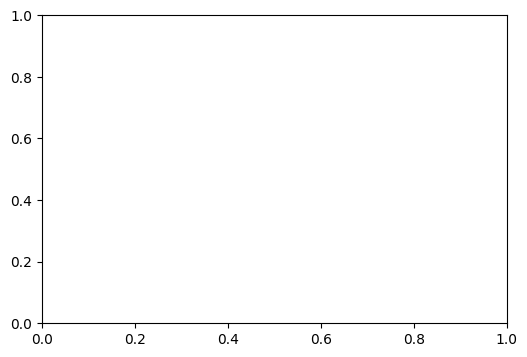

In [27]:
# plot loss
plt.figure(figsize=(6, 4))
plt.plot(range(history['epoch']), history['train_acc'], label='Train Acc')
plt.plot(range(history['epoch']), history['val_acc'], label='Val Acc')
plt.legend()
plt.show()